### Defining the Dubin's car model

For the Dubin’s model of a car the defining equations can be written as:
$$ \dot x  = v\ cos(θ)$$
$$\dot y  = v sin(θ)$$
$$\dot \theta = \frac{v}{L}tan(\theta) $$
Where $v$ is the linear velocity of the car, $x$ and $y$ are positions of the car on the 2d plane and $\theta$ is its angle with the x axis, and $\phi$ is the steering angle. $L$ is the distance between the wheel axles, which we assume to be 0.5 meters.

We also know that we cannot control any of these variables directly, so we use the control inputs acceleration $a$ and rate of steering ψ.

With these, we can arrive at the state space model

$$X = AX + U$$

Where $$X  = [x, y, \theta , v, \phi]^T$$ is the state vector, $$U = [a, \psi]$$ is the input or control vector and	$$\dot X  = [v\ cos(\theta), v\ sin(\theta) , \frac{V}{L} tan(\phi), a, \psi]^T$$ is the system equation.


### Sampling-Based Path Planning
We will begin by randomly sampling control values from a range of (-10,10) for acceleration and $\psi$ within (-3,3).

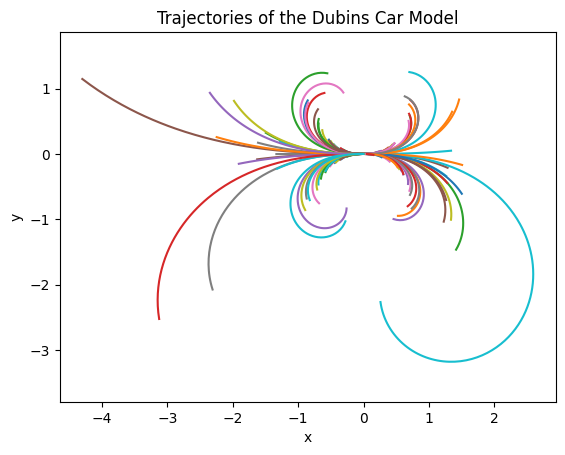

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

L = 0.5  # Length between the wheels
dt = 0.01  # Time step
simulation_time = 10  # Total simulation time
num_trajectories = 100  # Number of trajectories to simulate

def random_control(t):
    """Generate random acceleration and steering angle."""
    a = np.random.uniform(-10,10)
    psi = np.random.uniform(-3,3)
    return np.array([a, psi])

def check_constraints(state):
    """Check if the state violates any constraints."""
    v, phi = state[3], state[4]
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

trajectories = []  # Store trajectories here

for _ in range(num_trajectories):
  t = 0
  state = np.array([0, 0, 0, 0, 0])  # Initial state [x, y, theta, v, phi]
  trajectory = []
  control = random_control(t)
  for _ in np.arange(0, simulation_time, dt):
      state = dubin(state, control, dt)
      if check_constraints(state):
          break  # Stop this trajectory if constraints are violated
      trajectory.append(state[:2])  # Store only x and y for plotting
  trajectories.append(trajectory)
  t += t*dt

# Plotting
for trajectory in trajectories:
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Dubins Car Model')
plt.axis('equal')
plt.show()

Now, we define $a(t) = 10\ sin(10t+c)$ and $\psi(t) = 3\ sin(4t+d)$, and then sample $c$ and $d$ from the range $[0, 2\pi]$

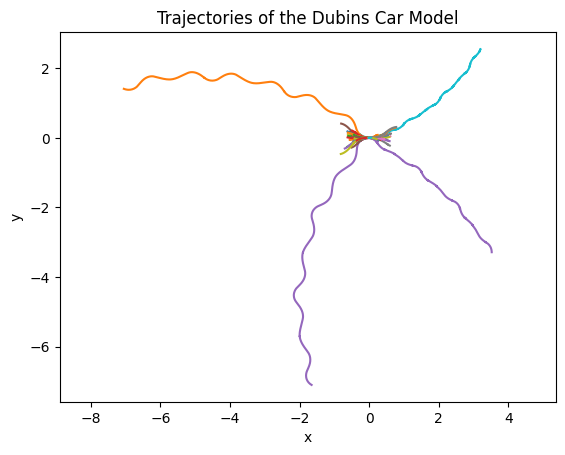

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

L = 0.5  # Length between the wheels
dt = 0.01  # Time step
simulation_time = 10  # Total simulation time
num_trajectories = 100  # Number of trajectories to simulate

def random_control(t):
    """Generate random acceleration and steering angle."""
    c = np.random.uniform(0, 2*np.pi)
    d = np.random.uniform(0, 2*np.pi)
    return np.array([c, d])

def check_constraints(state):
    """Check if the state violates any constraints."""
    x,y,_,v, phi = state
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3) and (-10) <= x <= (10) and (-10) <= y <= (10))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

trajectories = []  # Store trajectories here

for _ in range(num_trajectories):
  t = 0
  state = np.array([0, 0, 0, 0, 0])  # Initial state [x, y, theta, v, phi]
  trajectory = []
  #pick a c and d value
  c,d = random_control(t)
  for _ in np.arange(0, simulation_time, dt):
    a = 10*sin(10*t + c)
    psi = 4*sin(4*t + d)
    control = np.array([a,psi])
    state = dubin(state, control, dt)
    t += dt
    if check_constraints(state):
          break  # Stop this trajectory if constraints are violated
    trajectory.append(state[:2])  # Store only x and y for plotting
  trajectories.append(trajectory)


# Plotting
for trajectory in trajectories:
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Dubins Car Model')
plt.axis('equal')
plt.show()

### Probabilistic Roadmaps (PRM)

One important sampling-based planning approach is Probabilistic Roadmaps or PRM

### Kinodynamic Rapidly Expanding Random Trees (K-RRT)

One more important sampling-based approach is the RRT. Let us know build one for the above defined Dubin's car model, and since we will be sampling the controls, it will be a Kinodynamic RRT.

We will start from the initial state 0, sample a configuration $(p_x,p_y)$ in the range $[-10,10]$ and the rest of the constraints from above.

After selecting the nearest state, based on a distance metric, we will sample a random time step $\Delta t$ between [0s,1s] and simulate the system forward to reach the new node, and also reject all nodes that do not fulfil the above constraints.

Our distance metric would be the weighted Euclidean distance, except for the $\theta$ dimension which would be the geodesic distance in SO(2).

We simulate the RRT for 1000 iterations and plot the tree.

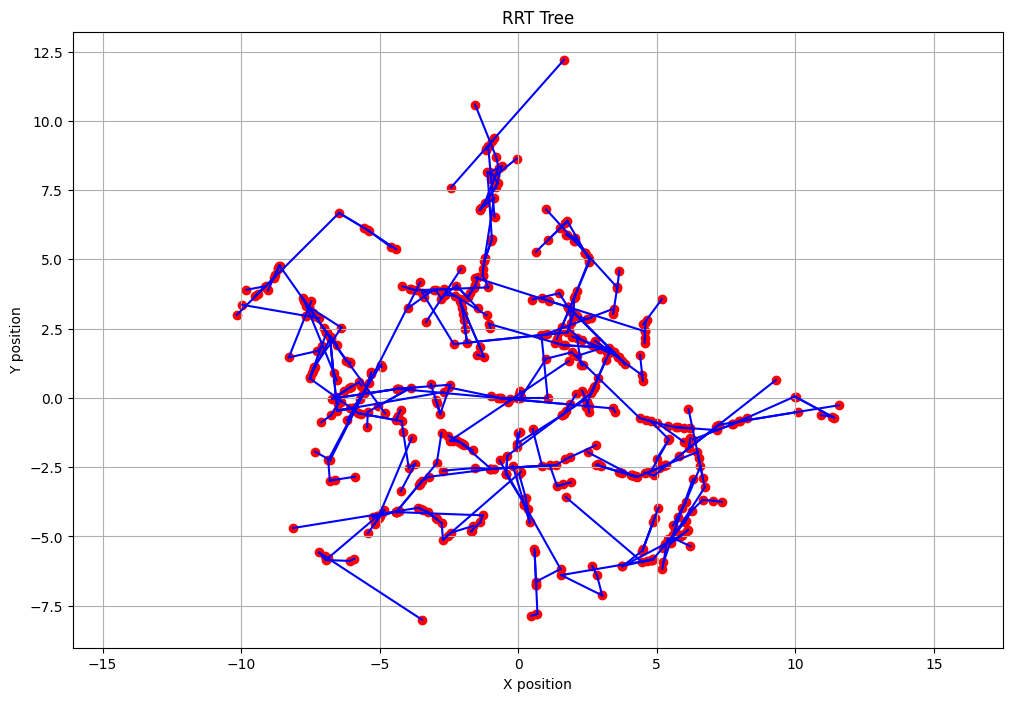

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

# Constants given in the problem
L = 0.5  # Length between the wheels

# Weights for the distance metric
w_x = 1
w_y = 1
w_theta = 1  # The weight for the geodesic distance in SO(2)
w_v = 1
w_phi = 1

# State space bounds
x_bounds = (-10, 10)
y_bounds = (-10, 10)
theta_bounds = (-pi, pi)
v_bounds = (-5, 5)
phi_bounds = (-pi/3, pi/3)

# Distance metric including the geodesic distance in SO(2)
def distance_metric(state1, state2):
    x1, y1, theta1, v1, phi1 = state1
    x2, y2, theta2, v2, phi2 = state2

    # Geodesic distance for theta
    d_theta = geodesic(theta1, theta2)

    # Weighted Euclidean distance
    dist = np.sqrt(
        w_x * (x1 - x2)**2 +
        w_y * (y1 - y2)**2 +
        w_theta * d_theta**2 +
        w_v * (v1 - v2)**2 +
        w_phi * (phi1 - phi2)**2
    )
    return dist

def geodesic(theta1, theta2):
    # Calculate the raw difference
    raw_diff = theta2 - theta1
    # Normalize the difference within the range -π to π
    if raw_diff > np.pi:
        return raw_diff - 2 * np.pi
    elif raw_diff <= -np.pi:
        return raw_diff + 2 * np.pi
    else:
        return raw_diff

# Random state generator
def random_state():
    x = np.random.uniform(*x_bounds)
    y = np.random.uniform(*y_bounds)
    theta = np.random.uniform(*theta_bounds)
    v = np.random.uniform(*v_bounds)
    phi = np.random.uniform(*phi_bounds)
    return np.array([x, y, theta, v, phi])

# The control input generator function
def random_control():
    a = np.random.uniform(-10, 10)
    psi = np.random.uniform(-3, 3)
    dt = np.random.uniform(0, 1)
    return np.array([a, psi, dt])

simulation_time = 10  # Total simulation time
num_trajectories = 1000  # Number of trajectories to simulate

def check_constraints(state):
    """Check if the state violates any constraints."""
    v, phi = state[3], state[4]
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

# The main loop to build the RRT with connections
def build_rrt_with_connections():
    nodes = [np.zeros(5)]  # Start with the initial state at the origin
    parents = [-1]  # -1 for the root node which has no parent
    for i in range(1000):
        rand_state = random_state()
        nearest_index = min(range(len(nodes)), key=lambda j: distance_metric(nodes[j], rand_state))
        control = random_control()
        new_state = dubin(nodes[nearest_index], control[:2], control[2])

        if not check_constraints(new_state):
            nodes.append(new_state)
            parents.append(nearest_index)  # Store the index of the nearest node as the parent

    return nodes, parents

# Running the RRT algorithm
rrt_tree, connections = build_rrt_with_connections()

# Plotting the RRT tree (x, y) positions with connections
plt.figure(figsize=(12, 8))
for i in range(1, len(rrt_tree)):
    # Draw a line from each node to its parent
    start_state = rrt_tree[connections[i]]
    end_state = rrt_tree[i]
    plt.plot([start_state[0], end_state[0]], [start_state[1], end_state[1]], 'b-')

# Plot the nodes on top of the connections
x_positions = [state[0] for state in rrt_tree]
y_positions = [state[1] for state in rrt_tree]
plt.scatter(x_positions, y_positions, c='r')

plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('RRT Tree')
plt.axis('equal')  # Equal scaling of the axes.
plt.grid(True)
plt.show()
